<a href="https://colab.research.google.com/github/estern95/Recipe-Mojo/blob/main/recipe_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's build a Recipe Generator!

In case you don't know me, I love cooking! I did multible cooking competitions in High School, and had I done a little better (2nd in both) I might have ended up doing something else. But then I would get to play around with tensorflow and build cool recipe generators!

# Notes

## Random Thoughts

* I think I want to train the recipe steps on the the list of ingredients. Then we have a model that links the ingredients to how they are used.
* This seems similar to how [image caption generators work](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/).
  * Simply put in image captioning, we train a model to identify what is in the image using a CNN and frequently a prebuilt model like VGG16. Then we merge it with a model that creates a partial caption.

    1. Processing the sequence from the text 
    1. Extracting the feature vector from the image
    1. Decoding the output using softmax by concatenating the above two layers

  * In my case, we don't have to use a CNN because our input data can be encoded as a matrix of ingredient quantities.
  * What might be tricky is that the 'caption' in my case is a lot longer since it is the list of steps.
    * What I am trying to decide is if it makes sense to define each step as a dimension in the shape? Or just treat the whole thing as a monolith. 
    * Probably easier to start with the monolithic approach, but a good thing to come back to at some point.
  * Eventually it would be cool to add a third merge layer of the recipe title. So the input would be a recipe title, and output a list of ingredients AND how to use them.
    * Start with the recipe encoder first :) trying to not overscope.

## Useful Links:

* [This is cool RNN to generate recipies](https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/recipe_generation_rnn/recipe_generation_rnn.ipynb#scrollTo=-Jka4jyNzoA0). It is naive though. The text looks like a recipe, but the recipes that is generates are meaningless because the steps don't match the ingredients.
* [Useful tututorial for creating image captions](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/)

## Outline the steps:

1. Get some data. I think we can get recipe data from an API called spoonacular. Let's just focus on deserts/baked goods since those recipes tend to be a bit more algorithmic. For instance, making cakes basically follows the exact same steps and is the reason a cake is a cake and not a muffin (Search for the muffin method vs creaming method if you are curious!).
1. Data cleaning, I expect that we will have a lot of cleaning to do. Beyond that the data will be pulled as JSON and we will have to convert to tabular data, there is probably a lot of small bits and bobs to normalize. For instance metric vs imperial units, Or even more confusing weights vs volume measures.
1. Design our model architechture! This is going to be a little tricky since there are a lot of ways we could go about this. For instance, a recipe is basically a DAG and we could treat it like so in our model and maybe treat it as a series. Or we could assume that all recipes of certain types follow the same steps and just feed it an array of ingredients/quantities. Probably best to start with that since we don't have to use text analysis to parse recipes strings.
1. Once we have a fitted model we like, we need to generate new results! Ideally, we give the model a key ingredient or perhaps a recipe name and the model will generate the rest. (This might need to leverage GANs but that is TBD)

## Extract Data

I was going to scrape data, but Kaggle to the rescue and someone has already done that work. There is a dataset scrapped from food.com with 700k recipes already organized!

# Pull Data With API

In [1]:
build_env = False #@param {type:"boolean"}
if build_env:
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle/
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d shuyangli94/food-com-recipes-and-user-interactions
  ! unzip  food-com-recipes-and-user-interactions.zip -d inout
  !wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
  !unzip -q glove.6B.zip

In [2]:
import pandas as pd
import numpy as np
import string
import os
from ast import literal_eval # for evaluating strings as lists

import matplotlib.pyplot as plt

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, GRU, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical, plot_model

recipes = pd.read_csv('inout/RAW_recipes.csv')

display(recipes)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10


## Take a look at one recipe

This confirms my idea to start with just treating the steps as a monolithic series. The steps are established by newlines and not the actual steps. 

In [3]:
print('Title:\n', recipes['name'].iloc[0])
print('Description:\n', recipes['description'].iloc[0])
print('Ingredients:\n', recipes['ingredients'].iloc[0])
print('Steps:\n', recipes['steps'].iloc[0])

Title:
 arriba   baked winter squash mexican style
Description:
 autumn is my favorite time of year to cook! this recipe 
can be prepared either spicy or sweet, your choice!
two of my posted mexican-inspired seasoning mix recipes are offered as suggestions.
Ingredients:
 ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Steps:
 ['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piece', 'season with mexican seasoning mix ii', 'for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece', 'season with sweet mexican spice mix', 'bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin', 'be careful not to burn the squash especially if you opt to use sugar or butter', 'if you feel more comfortable , cover the sq

## Preprocessing

Need to convert the vector of steps into a single string. Everything is already lowercase and purged of punctuation.



In [4]:

recipes['ingredients'] = recipes['ingredients'].apply(literal_eval)
recipes['steps'] = recipes['steps'].str.replace(r'-', ' ').str.replace(r'[^\w\s]+', '')
recipes['nwords_steps'] = recipes.steps.apply(lambda x: len(x.split()))

## Remove Recipes with Long Number of Steps

Most steps have less than 500 words. Since we will have to pad the sequences later, it will mean that every sequence will have to be the same length. Removing the longer sequences will pay dividends while fitting the model.

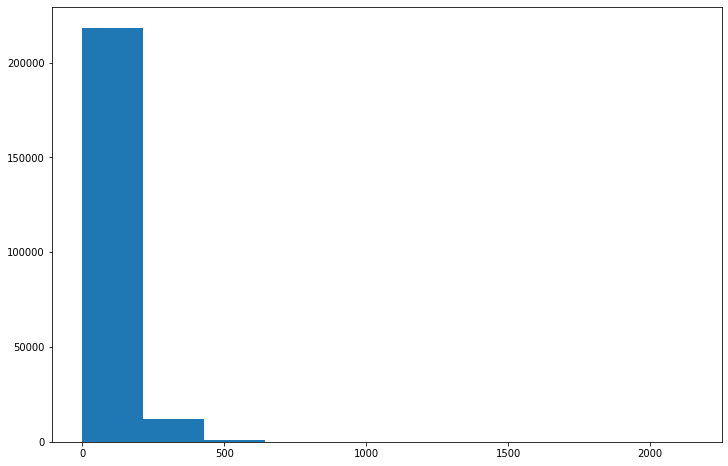

In [5]:
plt.figure(figsize=(12,8)) 
hist = plt.hist(recipes['nwords_steps'])

In [6]:
max_words_steps = 200

recipes = recipes[recipes.nwords_steps <= max_words_steps]

# For testing
recipes = recipes.sample(frac = .02)

print('%d recipes in training set' % len(recipes))

4306 recipes in training set


In [7]:
ingredients = recipes['ingredients']
steps       = recipes['steps']


Find the Corpus for all instructions:

In [8]:
steps_vocab = set()

for key in steps.keys():
  [steps_vocab.update(steps[key].split())]
print('Original Vocabulary Size: %d' % len(steps_vocab))


Original Vocabulary Size: 6155


Now we create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length.



In [9]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in steps_vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

We also need to find out what the max length of a steps set can be since we cannot have steps vector of arbitrary length.

In [10]:
length_steps = steps.apply(lambda x: len(x.split()))
max_length = max(length_steps)
print('Description Length: %d' % max_length)

Description Length: 200


## Glove Prepocessing

Word vectors map words to a vector space, where similar words are clustered together and different words are separated. The advantage of using Glove over Word2Vec is that GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors.

The basic premise behind Glove is that we can derive semantic relationships between words from the co-occurrence matrix. For our model, we will map all the words in our 2144-word long caption to a 200-dimension vector using Glove.

In [11]:
embeddings_index = {} 
f = open(os.path.join('glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

Next, we make the matrix of shape (45385, 200) consisting of our vocabulary and the 200-d vector.

In [12]:
embedding_dim = 200 # Taken from the pre-trained glove model
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Preprocessing for Ingredients
We are going to do simlar prep steps as we did for the description encodings.

First, we need to create a set of all possible ingredients.

In [13]:
ingredients_vocab = set()

for key in ingredients.keys():
  [ingredients_vocab.update(ingredients[key])]
print('Original Ingredient Set: %d' % len(ingredients_vocab))


Original Ingredient Set: 3974


Now we create two dictionaries to map ingredients to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length.

In [14]:
ixtoingredient = {}
ingredienttoix = {}
ix = 1
for w in ingredients_vocab:
    ingredienttoix[w] = ix
    ixtoingredient[ix] = w
    ix += 1

ingredient_size = len(ixtoingredient) + 1

Now we are going to create a spare matrix by hot encoding the ingredients as zero or one.

In [15]:

# integer representation
def prep_ingredients(ingredient_list, ingredienttoix, ingredient_size):
  bool_ingredients = np.zeros((ingredient_size), dtype=np.bool)
  
  #create a spare array. If an ingredieant is use, 1, else 0
  for ind in ingredient_list:
    bool_ingredients[ingredienttoix[ind]-1] = 1 

  return(bool_ingredients)


Now let’s define our model.
We are creating a Merge model where we combine the ingredient vector and the embeded steps list. Therefore our model will have 3 major steps:

* Processing the sequence from the text 
* Extracting the feature vector from the ingredients
* Decoding the output using softmax by concatenating the above two layers

In [16]:
inputs1 = Input(shape=(ingredient_size,))
fe0 = Dense(256, activation='relu')(inputs1)
fe1 = Dropout(0.5)(fe0)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = GRU(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3975)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          1017856     input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 200)     1231200     input_2[0][0]                    
______________________________________________________________________________________________

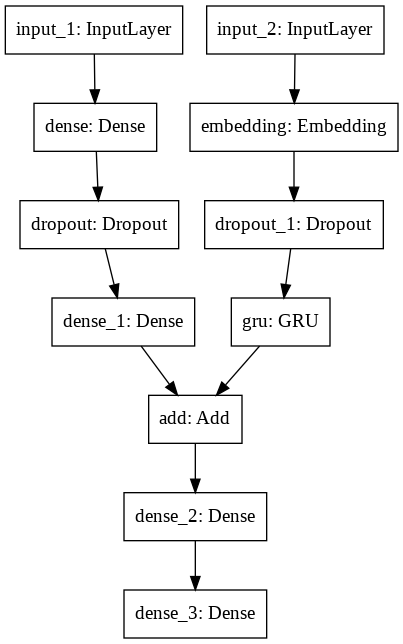

In [17]:
plot_model(model)

Now compile the model.

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [37]:
def data_generator(recipe_steps, 
                   recipe_ingredients, 
                   wordtoix, 
                   max_length, 
                   ingredienttoix,
                   ingredient_size,
                   num_recipes_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop forever over recipes
    while True:
        for key, desc in recipe_steps.items():
            n+=1
            ingredient_input = prep_ingredients(recipe_ingredients[key], 
                                                ingredienttoix,
                                                ingredient_size)
                # encode the sequence
            seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                
                # split one sequence into multiple X, y pairs
            #print(len(seq))
            for i in range(0, len(seq)):
                    # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                    
                    # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                X1.append(ingredient_input)
                X2.append(in_seq)
                y.append(out_seq)
                
            if n==num_recipes_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

#X1 = np.array(ingredients.apply(lambda x: prep_ingredients(x,
#                                                  ingredienttoix, 
#                                                  ingredient_size)))
#
#
# Sequence descriptions
 

In [ ]:
epochs = 30
batch_size = 10
epoch_steps = len(steps)//batch_size

generator = data_generator(steps, ingredients, 
                           wordtoix, max_length, 
                           ingredienttoix, ingredient_size,
                           batch_size)



model.fit(generator, epochs=epochs, steps_per_epoch=epoch_steps, verbose=1)

Epoch 1/30
430/430 [==============================] - 262s 608ms/step - loss: 4.6850
Epoch 2/30
430/430 [==============================] - 258s 600ms/step - loss: 4.2645
Epoch 3/30
430/430 [==============================] - 257s 597ms/step - loss: 3.9697
Epoch 4/30
430/430 [==============================] - 258s 599ms/step - loss: 3.7582
Epoch 5/30
430/430 [==============================] - 256s 594ms/step - loss: 3.5924
Epoch 6/30
430/430 [==============================] - 258s 599ms/step - loss: 3.4545
Epoch 7/30
241/430 [===============>..............] - ETA: 1:53 - loss: 3.3554

# Generate Our Recipes

Now that we have a fitted model that takes in a list of ingredients and a seed word, we can generate a recipe. There are two methods we can use: Beam Search and Greedy Search. 

**Beam Search** is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we reach the maximum length.

**Greedy Search** is where we pick the word with the highest probability to get the next word prediction.

In [ ]:
def beam_search_predictions(ingredient_set, beam_index = 3, start_seq):
    start = [wordtoix[start_seq]]
    start_word = [[start, 0.0]]

    ingredients_prepped = prep_ingredients(
        ingredient_set, 
        ingredienttoix,
        ingredient_size)
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([ingredients_prepped,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

def greedySearch(ingredient_set, start_seq):
    in_text = start_seq
    ingredients_prepped = prep_ingredients(
      ingredient_set, 
      ingredienttoix,
      ingredient_size)
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([ingredients_prepped,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final